### GWR 例子
***
这是一个基本的示例笔记本，演示了如何使用开源“mgwr”包在 Python 中校准 GWR（Fotheringham 等人，2002）模型。mgwr 包由 Oshan 等人（2019 年）开发，托管在 https://github.com/pysal/mgwr。

#### Installation
`pip install mgwr`

我们将使用佐治亚州的一个示例数据集，以下是数据中的一些变量。

**TotPop90** 1990 年县的人口

**PctRural** 县内定义为农村的人口百分比

**PctBach** 县内拥有学士学位的人口百分比

**PctEld** 县内 65 岁或以上的人口百分比

**PctFB** 县内出生在美国以外的人口百分比

**PctPov** 县内生活在贫困线以下的人口百分比

**PctBlack** 县内黑人人口百分比

***
我们将使用几个社会人口统计变量对县级教育程度进行建模。

***
模型为：

PctBach = b0 + b1 * PctFB + b2 * PctBlack + b3 * PctRural




Load packages

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
import libpysal as ps 
from libpysal.weights import Queen
from esda.moran import Moran

#MGWR functions
from mgwr.gwr import GWR
from mgwr.sel_bw import Sel_BW

从 pysal 加载 Georgia 数据集

In [3]:
georgia_shp = gpd.read_file("https://raw.github.com/Ziqi-Li/gis5122/master/data/georgia.geojson")

佐治亚州地图和每个县的质心。

/var/folders/mp/9px298sd6vs8xccb_3sql0dr0000gp/T/ipykernel_55115/3938808638.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  georgia_shp.centroid.plot(ax=ax, c='black',markersize = 10,aspect=1)


<Axes: >

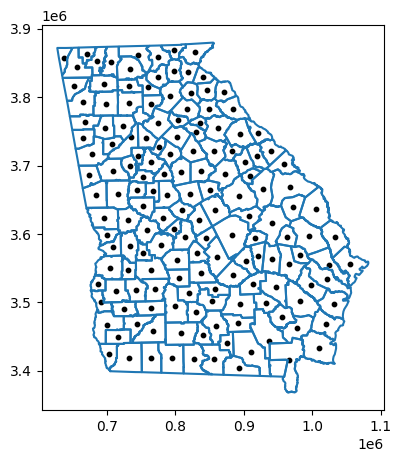

In [4]:
fig, ax = plt.subplots(figsize=(5,5))
georgia_shp.boundary.plot(ax=ax,aspect=1)

georgia_shp.centroid.plot(ax=ax, c='black',markersize = 10,aspect=1)

佐治亚州地图供参考
（来源：https://www.enchantedlearning.com/usa/states/georgia/map.GIF）

<img src=https://www.enchantedlearning.com/usa/states/georgia/map.GIF width="200" align="left">

我们可以映射因变量“PctBach”。

Text(0.5, 1.0, 'PctBach')

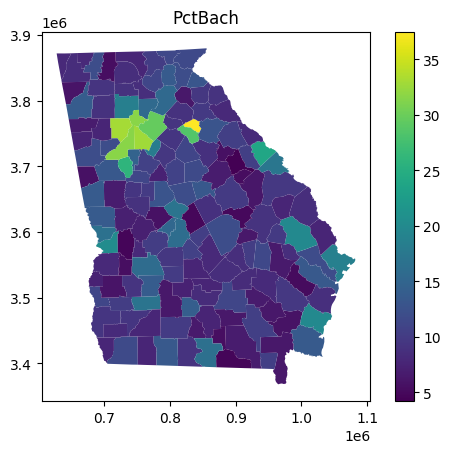

In [5]:
georgia_shp.plot(column="PctBach",legend=True,aspect=1)
plt.title("PctBach")

#### 模型规范：
PctBach = b0 + b1 * PctFB + b2 * PctBlack + b3 * PctRural
***
准备要输入到 mgwr 的 Georgia 数据集

In [6]:
y = georgia_shp['PctBach'].values

X = georgia_shp[['PctFB', 'PctBlack', 'PctRural']].values

u = georgia_shp['X']
v = georgia_shp['Y']

coords = list(zip(u,v))

### 标准化变量（可选）
- 将数据标准化，使平均值为 0，方差为 1。
- 参数估计的幅度是可比的。系数越大 -> 关系越强。

In [7]:
#Standardize variables
X = (X - X.mean(axis=0)) / X.std(axis=0)
y = (y - y.mean(axis=0)) / y.std(axis=0)

y = y.reshape(-1,1)

#### 两步拟合 GWR 模型
- 选择最佳带宽
- 使用最佳带宽拟合 GWR 模型
***
默认内核是自适应（最近邻居数）双平方。

In [8]:
gwr_selector = Sel_BW(coords, y, X)

gwr_bw = gwr_selector.search(verbose=True)

print("Selected optimal bandwidth is:", gwr_bw)

Bandwidth:  90.0 , score:  301.83
Bandwidth:  117.0 , score:  299.05
Bandwidth:  133.0 , score:  300.58
Bandwidth:  106.0 , score:  299.75
Bandwidth:  123.0 , score:  299.85
Bandwidth:  112.0 , score:  299.29
Bandwidth:  119.0 , score:  299.43
Bandwidth:  115.0 , score:  299.08
Selected optimal bandwidth is: 117.0


使用最佳 bw 拟合模型

In [9]:
gwr_results = GWR(coords, y, X, bw=gwr_bw).fit()

GWR 输出摘要

In [10]:
gwr_results.summary()

Model type                                                         Gaussian
Number of observations:                                                 159
Number of covariates:                                                     4

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                             71.793
Log-likelihood:                                                    -162.399
AIC:                                                                332.798
AICc:                                                               335.191
BIC:                                                               -713.887
R2:                                                                   0.548
Adj. R2:                                                              0.540

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

局部估计值可以从“gwr_results.params”中获得，它返回一个 n x p 数组，其中 p 是模型中的预测变量的数量（包括截距）。

Text(0.5, 1.0, 'Coefficients of Pct PctRural')

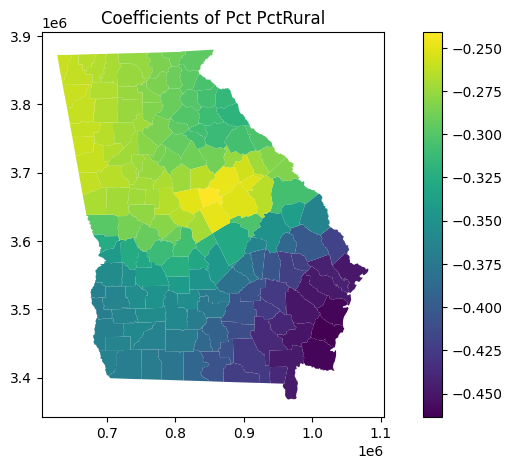

In [11]:
from matplotlib import colors

ax = georgia_shp.plot(column=gwr_results.params[:,3],figsize=(10,5),legend=True, 
                     linewidth=0.0,aspect=1)

plt.title("Coefficients of Pct PctRural",fontsize=12)

编写一些绘图代码，将参数估计表面全部可视化。我们需要将 GWR 结果与县 GeoDataFrame 连接起来。

In [12]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mgwr.utils import shift_colormap,truncate_colormap
from matplotlib import cm,colors

def param_plots(result, gdf, names=[], filter_t=False):
    
    #Size of the plot. Here we have a 2 by 2 layout.
    fig, axs = plt.subplots(2, 2, figsize=(10, 10))
    axs = axs.ravel()
    
    k = gwr_results.k
    
    #The max and min values of the color bar.
    vmin = -0.8
    vmax = 0.8
    
    cmap = cm.get_cmap("coolwarm")
    norm = colors.BoundaryNorm(np.arange(-0.8,0.9,0.1),ncolors=256)
    
    
    for j in range(k):
        
        pd.concat([gdf,pd.DataFrame(np.hstack([result.params,result.bse]))],axis=1).plot(ax=axs[j],column=j,vmin=vmin,vmax=vmax,
                                                                                         cmap="bwr",norm=norm,linewidth=0.1,edgecolor='white',aspect=1)
        axs[j].set_title("Parameter estimates of \n" + names[j],fontsize=10)
        
        if filter_t:
            rslt_filtered_t = result.filter_tvals()
            if (rslt_filtered_t[:,j] == 0).any():
                gdf[rslt_filtered_t[:,j] == 0].plot(color='grey', ax=axs[j],linewidth=0.1,edgecolor='white',aspect=1)
        
        #plt.axis('off')
    
    fig = axs[j].get_figure()
    cax = fig.add_axes([0.99, 0.2, 0.025, 0.6])
    sm = plt.cm.ScalarMappable(cmap=cmap,norm=norm)
    # fake up the array of the scalar mappable. Urgh...
    sm._A = []
    fig.colorbar(sm, cax=cax)

#### 以下是从 GWR 获得的参数估计图。每个图代表每个预测因子与 PctBach 之间的空间关系。

- 正（负）关系以红色（蓝色）显示。
- 较强（较弱）的关系颜色较深（较浅）。

/var/folders/mp/9px298sd6vs8xccb_3sql0dr0000gp/T/ipykernel_55115/1271372694.py:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap("coolwarm")


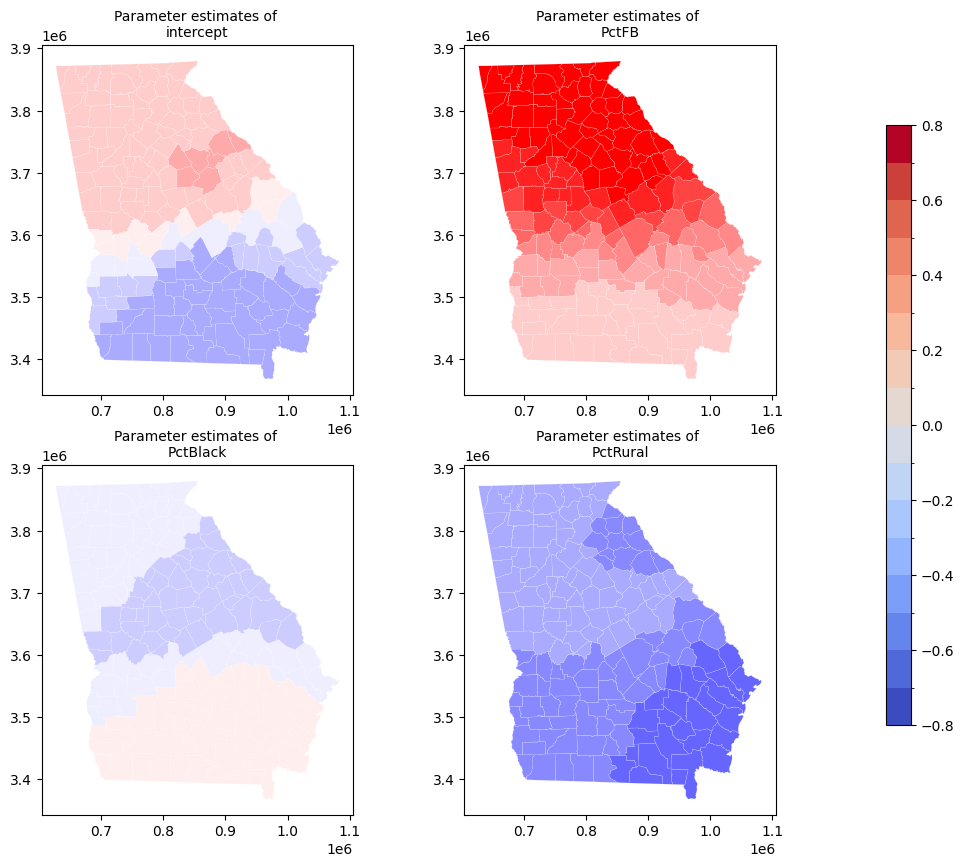

In [13]:
param_plots(gwr_results, georgia_shp, names=['intercept','PctFB', 'PctBlack', 'PctRural'])

现在让我们检查一下 GWR 模型的残差。

In [14]:
#Here we use the Queen contiguity
w = Queen.from_dataframe(georgia_shp)

#row standardization
w.transform = 'R'

/var/folders/mp/9px298sd6vs8xccb_3sql0dr0000gp/T/ipykernel_55115/876426650.py:2: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w = Queen.from_dataframe(georgia_shp)


In [15]:
georgia_moran = Moran(gwr_results.resid_response.reshape(-1), 
                         w, permutations = 199) #199 permutations
georgia_moran.I

0.040101374209262214

我们经常看到 GWR 模型的残差具有随机模式，这表明空间异质性和自相关性都被考虑在内。局部截距在解释空间自相关性方面发挥着作用，其作用类似于空间误差模型中的自回归误差分量。


### GWR 推断

局部系数显著性

#### 以下是**显著性（p<0.05）**参数估计值的图。显著性检验已调整以解决多重检验问题。
不显著的参数用灰色遮盖。例如，您可以发现，尽管我们在回归系数中看到了这种模式，但 PctBlack 和 PctBach 之间的关联实际上并不显著。


/var/folders/mp/9px298sd6vs8xccb_3sql0dr0000gp/T/ipykernel_55115/1271372694.py:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap("coolwarm")


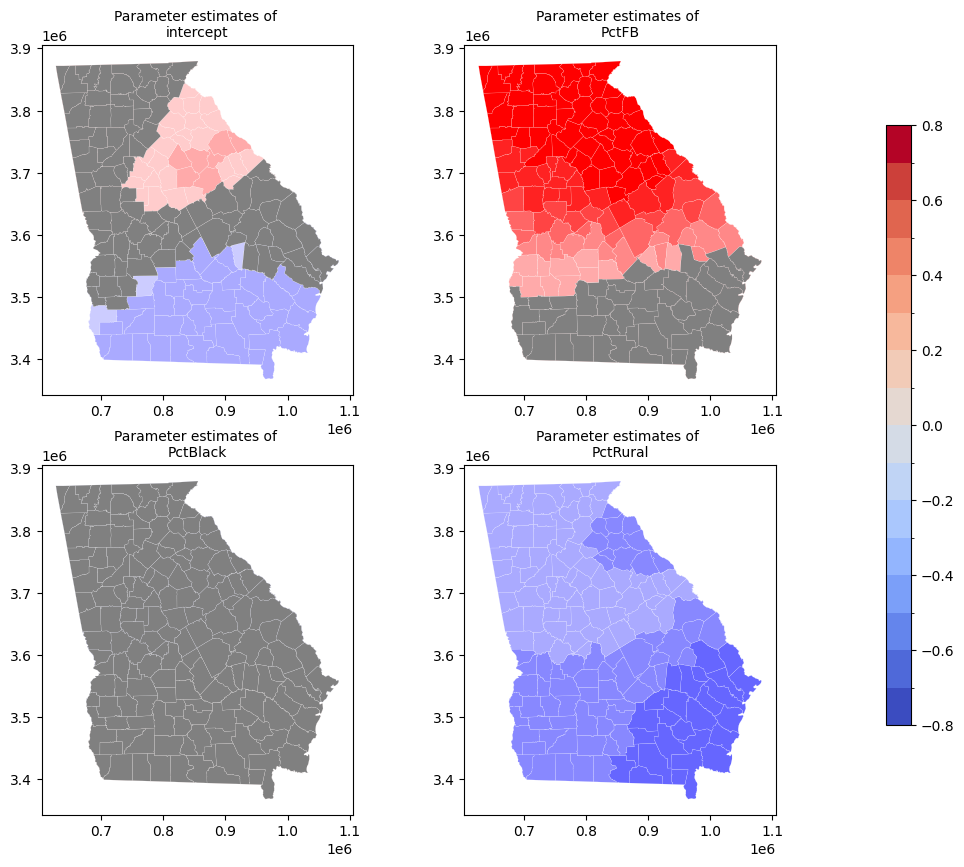

In [16]:
param_plots(gwr_results, georgia_shp,names=['intercept',
                                            'PctFB', 'PctBlack', 'PctRural'],
            
            filter_t=True)